# Application of Doc2vec for edX MOOCs dataset - Part II


## Introduction

In this work we verify the quallity of the embeddings learned in the [first part of edX MOOC analysis](https://github.com/zarina-aniraz/Analysis-of-edX-MOOCs/blob/master/Part1_Building_Model.ipynb).

## Loading saved doc2vec model

We load a corresoning course labels from csv files

In [37]:
from gensim.models import Doc2Vec

model0 = Doc2Vec.load("model0")
len(model0.docvecs)

csv_file = 'course_to_cat.csv'
df = pd.read_csv(csv_file)
course_to_cat=dict(zip(list(df.course), list(df.category)))

## Plot the distribution of number of courses per subject category

Counter({'Computer Science': 69, 'Business & Management': 54, 'Engineering': 26, 'Social Sciences': 19, 'Math': 16, 'Humanities': 14, 'Physics': 13, 'History': 8, 'Data Analysis & Statistics': 7, 'Literature': 6, 'Communication': 6, 'Biology & Life Sciences': 5, 'Health & Safety': 5, 'Art & Culture': 5, 'Education & Teacher Training': 5, 'Philosophy & Ethics': 4, 'Economics & Finance': 4, 'Chemistry': 3, 'Science': 3, 'Environmental Studies': 3, 'Language': 2, 'Medicine': 2, 'Electronics': 2, 'Law': 1, 'Architecture': 1, 'Energy & Earth Sciences': 1, 'Design': 1})
27


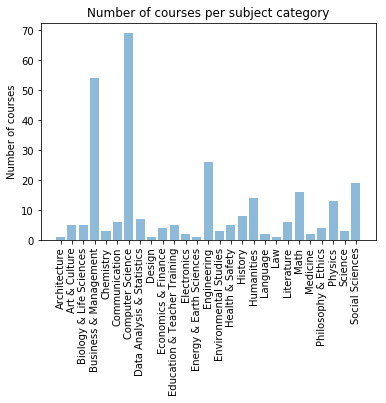

In [100]:
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(value for key,value in course_to_cat.items())
print(counts)
 
y = list(counts.values())
x = list(counts.keys())

print (len(x))

plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Number of courses')
plt.title('Number of courses per subject category')
plt.xticks(x, x, rotation='vertical')
 
plt.show()

We see that the number of courses per subjects varies. There are 56 courses on Computer Science, and only one course in  Architecture.   To  eliminated  the  bias  of  the  imbalanced  data  set,  we  classified  MOOCs  into  3 subject categories: 
* Business & Management 
* Compute Science
* Humanities.  

Because there are few courses available from Humanities category, we combined courses from related categories under one general "Humanities" category. The courses from the following subject categories were combined: Humanities, Literature, History, Communication, Art & Culture, Philosophy & Ethics, Language, and SocialSciences.

In [70]:
categ = {'Business & Management' : 0,
         'Computer Science': 1,
         'Humanities' : 2,
         'Literature' : 2, 
         'History' : 2,
         'Communication' : 2,
         'Art & Culture' : 2, 
         'Philosophy & Ethics' : 2, 
         'Language' : 2,  
         'Social Sciences' : 2}

X = [] # vectors
y = [] # categories

# select 54 (maximum possible) courses from each category for classification (both train and test)
counters = [0, 0, 0] # 0 - Business & Management, 1 - Compute Science, 2 - Humanities
for key, val in course_to_cat.items():
    if val in categ:
        ind = categ[val]
        if counters[ind]<54:
            X.append(models[0].docvecs[key])
            y.append(ind)
            counters[ind]+=1

In [18]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple
from smart_open import smart_open

from nltk.stem import PorterStemmer
import os,re,json

import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Defining classifiers

In [82]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Log regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    svm.SVC()
]

Split the dataset into train and test

In [86]:
from sklearn.cross_validation import train_test_split           

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for clf in classifiers:
    clf.fit(X_train, y_train)
    print (clf)
    print ("Accuracy: ", clf.score(X_test, y_test), "\n")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Accuracy:  0.851851851852 

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy:  0.833333333333 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy:  0.296296296296 

GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
             multi_class='one_vs_rest', n_jobs=1, n_restarts_optimizer=0,
             optimizer='fmin_l_bfgs_b', random_state=None,
             warm_start=False)
Accuracy:  0.833333333333

Defining a function for plotting a confusion matrix

In [98]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[15  1  0]
 [ 3 15  1]
 [ 4  0 15]]
Normalized confusion matrix
[[ 0.94  0.06  0.  ]
 [ 0.16  0.79  0.05]
 [ 0.21  0.    0.79]]


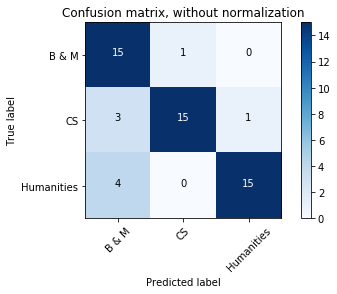

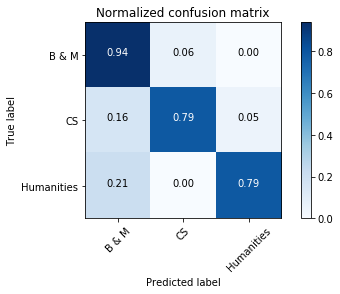

In [99]:
clf = svm.SVC()
y_pred = clf.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
categs=["B & M", "CS", "Humanities"]
plot_confusion_matrix(cnf_matrix, classes=categs,
                      title='Confusion matrix, without normalization')
plt.savefig("conf1.png")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=categs, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("conf2.png")
plt.show()